# Modelling

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Add the '../imports' directory to the sys.path list
import sys
sys.path.append('../imports')
from helper_functions import split_datetime
from data_preprocessing import merge_data, remove_col


## Import Data

In [2]:
# Get the train data

DATA_DIR = "../data/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client_train = pd.read_csv(DATA_DIR + "client.csv")
historical_weather_train = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather_train = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity_prices_train = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas_prices_train = pd.read_csv(DATA_DIR + "gas_prices.csv")
weather_station_to_county_mapping = pd.read_csv(DATA_DIR + 'weather_station_to_county_mapping.csv')

## Data Preprocessing

In [3]:
# We merge all DataFrames 
merged_train_df = merge_data(train, client_train, historical_weather_train,
        forecast_weather_train, electricity_prices_train, gas_prices_train, weather_station_to_county_mapping)

In [4]:
# Drop all non needed columns (ids and timestamps)
model_df = remove_col(merged_train_df)

In [5]:
model_df

,county,is_business,product_type,target,is_consumption,eic_count_client,installed_capacity_client,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,euros_per_mwh_electricity_prices,...,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,year,month,week,hour,day_of_year,day_of_month,day_of_week
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,15.0,620.0,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2
2018348,15,1,1,0.000,0,20.0,624.5,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2
2018349,15,1,1,28.404,1,20.0,624.5,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2
2018350,15,1,3,0.000,0,55.0,2188.2,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2


## Train-Test-Split

In [13]:
X = model_df.drop('target', axis=1)
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Train the Model

We take the parameters from the model optimization (notebook 2.2)

In [14]:
model = XGBRegressor(enable_categorical=True, max_depth=9, learning_rate=0.3)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluate Model

In [15]:
# Train Data

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# main optimisation metric
print('Mean absolute error test', mean_absolute_error(y_test, y_test_pred))
print('Mean absolute error train', mean_absolute_error(y_train, y_train_pred))

Mean absolute error test 33.03026143971082
Mean absolute error train 28.261521604144423


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

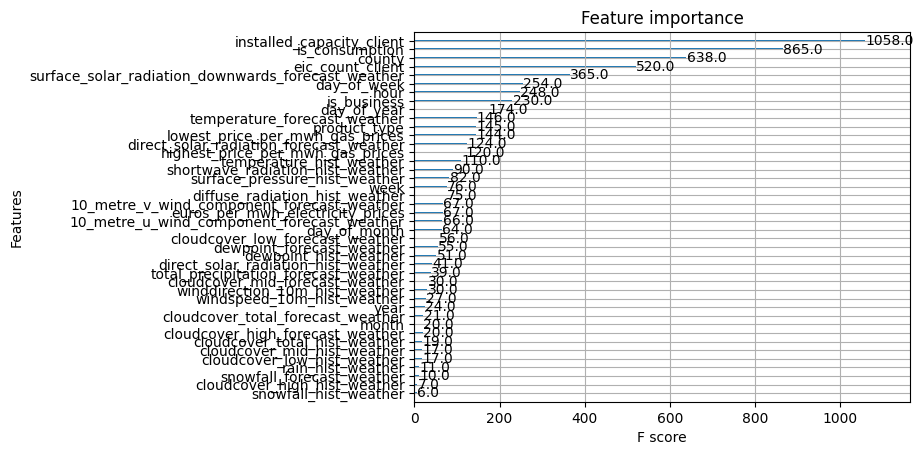

In [7]:
xgb.plot_importance(bst)

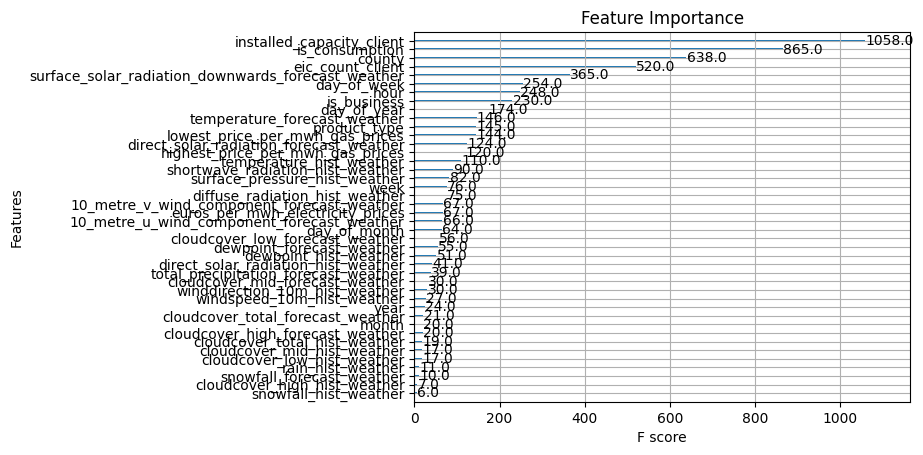

In [8]:
xgb.plot_importance(bst)
plt.title('Feature Importance')
plt.show()

- residuals are bigger at the summer time, we quess because production is happening at this time

- residuals on the test data have weekly pattern
- last two month predicted very poorly

- residuals are different depending on how we split our data 
- we see unexpalinable patterns in residuals
- residuals for consumption and production correlate with different features

- try residual analysis with traditional test_train_split

- tweak the model

> We tried to split the data into old and new data for training and testing. Because of bad scores we continue with a random train-test-split.

In [9]:
# split of old data to train and newer one to test

# Xy_train = model_df[model_df.data_block_id < 450]
# X_train = Xy_train.drop('target', axis=1)
# y_train = Xy_train.target

# Xy_test = model_df[model_df.data_block_id >= 450]
# X_test = Xy_test.drop('target', axis=1)
# y_test = Xy_test.target

# bst = XGBRegressor(enable_categorical=True)
# bst.fit(X_train, y_train)
# y_pred = bst.predict(X_test)

# # main optimisation metric
# print('Mean absolute error test', mean_absolute_error(y_test, y_pred))
# print('Mean absolute error train', mean_absolute_error(y_train, bst.predict(X_train)))

In [10]:
# divide by dates and use newer ones for validation

In [11]:
# target_column = 'residual'

# # Exclude non-numeric columns
# numeric_columns = Xy_test.select_dtypes(include=['number']).columns
# numeric_df = Xy_test[numeric_columns]
# numeric_df_cons = numeric_df[numeric_df['is_consumption'] == 1]

# # Calculate the correlation matrix
# correlation_matrix = numeric_df_cons.corr()

# # Select correlations based on the threshold
# threshold = 0.15
# significant_correlations = correlation_matrix[(correlation_matrix[target_column] > threshold) | (correlation_matrix[target_column] < -threshold)][target_column]

# # Plot a heatmap of the significant correlations with the target
# plt.figure(figsize=(12, 8))
# sns.heatmap(significant_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
# plt.title(f'Significant Correlations with {target_column}, CONSUM ONLY (Threshold: {threshold})')
# plt.show()

In [12]:
# target_column = 'residual'

# # Exclude non-numeric columns
# numeric_columns = Xy_test.select_dtypes(include=['number']).columns
# numeric_df = Xy_test[numeric_columns]
# numeric_df_cons = numeric_df[numeric_df['is_consumption'] == 0]

# # Calculate the correlation matrix
# correlation_matrix = numeric_df_cons.corr()

# # Select correlations based on the threshold
# threshold = 0.15
# significant_correlations = correlation_matrix[(correlation_matrix[target_column] > threshold) | (correlation_matrix[target_column] < -threshold)][target_column]

# # Plot a heatmap of the significant correlations with the target
# plt.figure(figsize=(12, 8))
# sns.heatmap(significant_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
# plt.title(f'Significant Correlations with {target_column}, PRODUCTION ONLY (Threshold: {threshold})')
# plt.show()